Geminiで生成したコード（ちゃんと動く）

In [1]:
import numpy as np
from pyscf import gto, scf, fci, ao2mo
import random

class SimpleFCIQMC:
    def __init__(self, mol, n_walkers=1000, time_step=0.01, steps=5000):
        self.mol = mol
        self.N_w_target = n_walkers  # 目標ウォーカー数
        self.dt = time_step          # タイムステップ (tau)
        self.steps = steps           # 反復回数
        self.shift = 0.0             # エネルギーシフト (S)
        self.damping = 0.1           # シフト更新の減衰パラメータ
        
        # ハミルトニアン行列の準備
        self.H_mat, self.e_hf, self.norb, self.nelec = self._build_hamiltonian()
        
        # 基底状態（Hartree-Fock解）のインデックスを特定
        # PySCFのFCIでは通常、最初の行列要素がHF状態に対応します
        self.ref_det_idx = 0 
        
        # ウォーカーの初期化 {det_index: signed_population}
        # 符号付き整数で管理（+1, -1など）
        self.walkers = {self.ref_det_idx: self.N_w_target}
        
        # 統計用
        self.energy_hist = []

    def _build_hamiltonian(self):
        """PySCFを使ってFCIハミルトニアン行列全体を生成する"""
        # 1. RHF計算
        mf = scf.RHF(self.mol).run(verbose=0)
        h1 = mf.get_hcore()
        h2 = mf._eri
        
        # 2. 分子軌道(MO)積分へ変換
        norb = mf.mo_coeff.shape[1]
        nelec = self.mol.nelectron
        h1_mo = np.dot(mf.mo_coeff.T, np.dot(h1, mf.mo_coeff))
        h2_mo = ao2mo.kernel(self.mol, mf.mo_coeff)
        
        # 3. 全CIハミルトニアン行列の生成
        # 注意: H2/STO-3Gのような小規模系でのみ可能です。
        # 大規模系ではオンザフライで行列要素を計算する必要があります。
        cisolver = fci.direct_spin1.FCI(self.mol)
        h2_mo_restore = ao2mo.restore(1, h2_mo, norb)
        H_mat = fci.direct_spin1.pspace(h1_mo, h2_mo_restore, norb, nelec)[1]
        print('H_mat: ', H_mat)
        
        return H_mat, mf.e_tot, norb, nelec

    def run(self):
        print(f"Starting FCIQMC for {self.mol.atom}...")
        print(f"Hartree-Fock Energy: {self.e_hf:.6f} Ha")
        
        diag_H = np.diag(self.H_mat)
        
        # シフトの初期値をHFエネルギー付近に設定（核反発エネルギー込み）
        # H_matは電子ハミルトニアンなので、核反発を加える必要があるが、
        # ここではダイナミクスのためにH_matの基底期待値に合わせる
        self.shift = diag_H[self.ref_det_idx]
        print('shfit: ', self.shift)

        for step in range(self.steps):
            new_walkers = {}
            
            # --- 1. Spawning & Death/Cloning Step ---
            # 現在の全ウォーカーに対してループ
            current_dets = list(self.walkers.keys())
            
            for i in current_dets:
                n_i = self.walkers[i] # 決定基i上のウォーカー数（符号付き）
                if n_i == 0: continue
                
                # A. Diagonal Step (Death/Cloning)
                # Pd = exp(-dt * (H_ii - S)) - 1  ~ -dt * (H_ii - S)
                # ここでは単純な一次近似を使用
                h_ii = diag_H[i]
                prob_death = self.dt * (h_ii - self.shift)
                # 既存のウォーカー数 n_i を増減させる
                # 確率的に床関数/天井関数を使って整数化
                change = -(n_i * prob_death)
                
                # 確率的整数化 (Stochastic rounding)
                change_int = int(change)
                if random.random() < abs(change - change_int):
                    change_int += int(np.sign(change))
                
                # 生き残ったウォーカーを一時リストに追加
                if i not in new_walkers: new_walkers[i] = 0
                new_walkers[i] += n_i + change_int

                # B. Off-Diagonal Step (Spawning)
                # 決定基 i から j へのスポーニング
                # 通常は接続された決定基をランダムサンプリングするが、
                # ここでは行列が小さいため、接続している全 j を走査（簡単のため）
                row = self.H_mat[i]
                # 非ゼロ要素のインデックスを取得（自分自身を除く）
                connected_dets = np.where(row != 0)[0]
                
                for j in connected_dets:
                    if i == j: continue
                    h_ij = row[j]
                    
                    # Spawning probability: Ps = dt * |H_ij|
                    # 生成される数: sign(walker) * sign(-H_ij)
                    prob_spawn = self.dt * abs(h_ij)
                    n_spawn = abs(n_i) * prob_spawn
                    
                    # 確率的整数化
                    n_spawn_int = int(n_spawn)
                    if random.random() < (n_spawn - n_spawn_int):
                        n_spawn_int += 1
                    
                    if n_spawn_int > 0:
                        # 符号の決定 (反対称性を考慮: H_ij < 0 なら同符号、H_ij > 0 なら異符号)
                        child_sign = np.sign(n_i) * -np.sign(h_ij)
                        
                        if j not in new_walkers: new_walkers[j] = 0
                        new_walkers[j] += int(child_sign * n_spawn_int)

            # --- 2. Annihilation Step ---
            # new_walkers辞書への加算処理ですでに、同じ決定基上の
            # 正負のウォーカーは相殺（Annihilation）されている。
            # 数が0になった決定基を削除
            self.walkers = {k: v for k, v in new_walkers.items() if v != 0}
            
            # --- 3. Shift Update ---
            total_walkers = sum(abs(w) for w in self.walkers.values())
            if step > 500: # 初期緩和後
                self.shift -= (self.damping / self.dt) * np.log(total_walkers / self.N_w_target)
            
            # --- 4. Energy Estimation (Projected Energy) ---
            # E = <D0|H|Psi> / <D0|Psi>
            # HF決定基(D0)上のウォーカー数と、D0からつながるH要素で計算
            
            num_ref = self.walkers.get(self.ref_det_idx, 0)
            if num_ref != 0:
                # Hの対角成分（D0のエネルギー）
                energy_proj = diag_H[self.ref_det_idx]
                
                # Hの非対角成分からの寄与 (sum_{j!=0} H_0j * N_j) / N_0
                off_diag_sum = 0
                row0 = self.H_mat[self.ref_det_idx]
                for det_idx, n_w in self.walkers.items():
                    if det_idx != self.ref_det_idx:
                        off_diag_sum += row0[det_idx] * n_w
                
                energy_proj += off_diag_sum / num_ref
                
                # 核反発エネルギーを足して全エネルギーへ
                total_energy = energy_proj + self.mol.energy_nuc()
                self.energy_hist.append(total_energy)
            
            if step % 500 == 0:
                print(f"Step {step}: Walkers={total_walkers}, Shift={self.shift:.5f}, E_proj={self.energy_hist[-1] if self.energy_hist else 0:.6f}")

        return np.mean(self.energy_hist[-1000:]) # 最後の1000ステップの平均

# --- 実行 ---
# H2分子の定義 (0.74 Angstrom)
mol = gto.M(atom='H 0 0 0; H 0 0 0.74', basis='sto-3g', verbose=0)

# FCIQMCの実行
fci_qmc = SimpleFCIQMC(mol, n_walkers=2000, time_step=0.005, steps=10000)
fci_energy = fci_qmc.run()

# 正解値（厳密な対角化）との比較
print("-" * 30)
print(f"Final FCIQMC Energy: {fci_energy:.6f} Ha")

# PySCFの厳密解(FCI)
# cisolver = fci.FCI(mol, scf.RHF(mol).run(verbose=0))
# print(f"Exact FCI Energy   : {cisolver.kernel()[0]:.6f} Ha")

H_mat:  [[-1.83186365e+00 -5.22608557e-16 -4.67083728e-16  1.81210462e-01]
 [-5.22608557e-16 -1.06466723e+00  1.81210462e-01 -1.64624263e-17]
 [-4.67083728e-16  1.81210462e-01 -1.06466723e+00  8.67705089e-17]
 [ 1.81210462e-01 -1.64624263e-17  8.67705089e-17 -2.52486193e-01]]
Starting FCIQMC for H 0 0 0; H 0 0 0.74...
Hartree-Fock Energy: -1.116759 Ha
shfit:  -1.831863646477506
Step 0: Walkers=2002, Shift=-1.83186, E_proj=-1.116941
Step 500: Walkers=2301, Shift=-1.83186, E_proj=-1.136884
Step 1000: Walkers=1994, Shift=-10.74276, E_proj=-1.137524
Step 1500: Walkers=1728, Shift=0.79699, E_proj=-1.138223
Step 2000: Walkers=2082, Shift=6.12420, E_proj=-1.136230
Step 2500: Walkers=2252, Shift=-6.41220, E_proj=-1.136675
Step 3000: Walkers=1864, Shift=-7.86604, E_proj=-1.137447
Step 3500: Walkers=1834, Shift=3.98405, E_proj=-1.137334
Step 4000: Walkers=2195, Shift=2.96224, E_proj=-1.137456
Step 4500: Walkers=2147, Shift=-8.99252, E_proj=-1.137552
Step 5000: Walkers=1803, Shift=-4.39851, E_pro

## 2025/11/27 生成

projected_energyはいい線いっているがshiftが振動している。

Starting FCIQMC Simulation...
Hartree-Fock Energy: -1.116701
Step 0: Pop=101.0, Shift=0.00000, E_proj=-1.11670
Step 200: Pop=320.0, Shift=0.00000, E_proj=-1.12879
Step 400: Pop=620.0, Shift=20.65352, E_proj=-1.13435
Step 600: Pop=2120.0, Shift=16.09160, E_proj=-1.13455
Step 800: Pop=3060.0, Shift=-8.59632, E_proj=-1.13575
Step 1000: Pop=1127.0, Shift=-24.43418, E_proj=-1.13651
Step 1200: Pop=351.0, Shift=-10.77152, E_proj=-1.13871
Step 1400: Pop=390.0, Shift=14.93889, E_proj=-1.13627
Step 1600: Pop=1329.0, Shift=22.18083, E_proj=-1.13822
Step 1800: Pop=3247.0, Shift=2.73621, E_proj=-1.13550
Step 2000: Pop=1983.0, Shift=-21.18468, E_proj=-1.13817
Step 2200: Pop=496.0, Shift=-19.76385, E_proj=-1.13703
Step 2400: Pop=306.0, Shift=5.70364, E_proj=-1.13714
Step 2600: Pop=792.0, Shift=23.35799, E_proj=-1.13850
Step 2800: Pop=2644.0, Shift=13.04682, E_proj=-1.13530


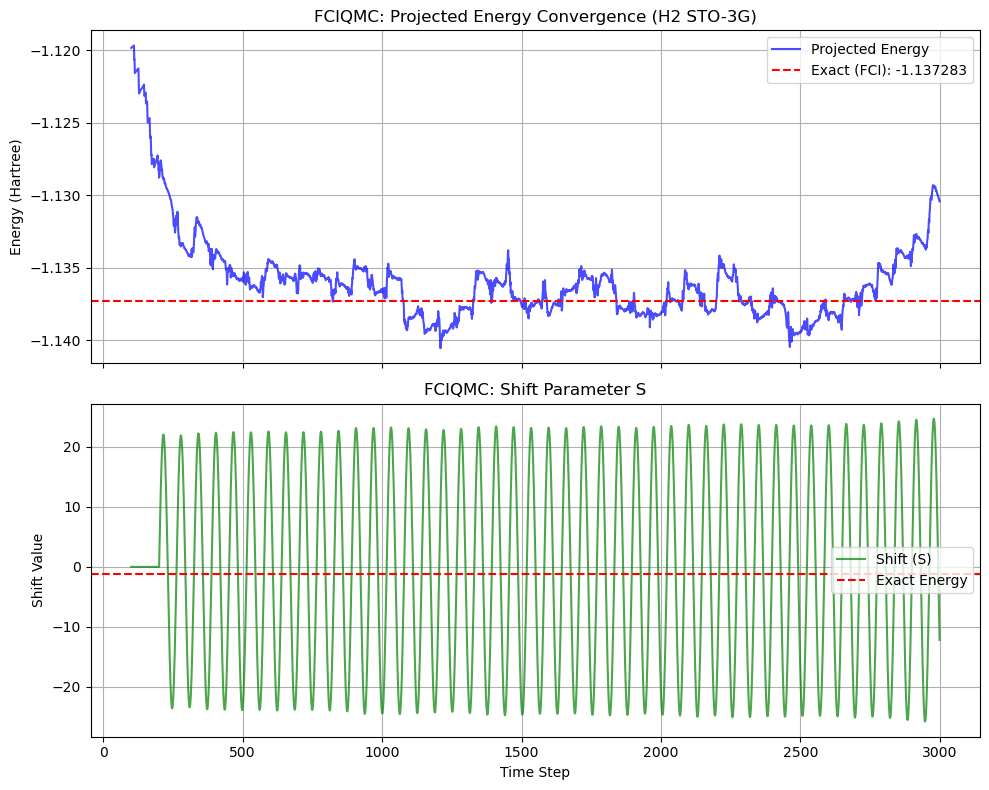


Final Estimated Energy (last 500 steps avg): -1.135873 Hartree
Shift (last 500 steps avg): -0.267460 Hartree
Exact FCI Energy: -1.137283 Hartree


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import random

class H2Hamiltonian:
    """
    H2分子 (STO-3G, R=1.4 Bohr) のハミルトニアンを管理するクラス。
    積分値はハードコードされています。
    """
    def __init__(self):
        # 核反発エネルギー
        self.E_nuc = 0.71375399
        
        # 1電子積分 (h_pq) - 空間軌道 basis (2軌道)
        # values taken from a standard STO-3G H2 calculation at R=1.4 au
        self.h1 = np.array([
            [-1.25247749, 0.0],
            [0.0, -0.47593400]
        ])
        
        # 2電子積分 (g_pqrs = <pq|rs>) in Chemist notation
        # g[p,q,r,s] corresponds to spatial orbitals
        self.g2 = np.zeros((2, 2, 2, 2))
        self.g2[0, 0, 0, 0] = 0.674493166
        self.g2[0, 0, 1, 1] = 0.181287518
        self.g2[1, 1, 0, 0] = 0.181287518
        self.g2[1, 1, 1, 1] = 0.697397921
        self.g2[0, 1, 1, 0] = 0.181287518 # Exchange
        self.g2[1, 0, 0, 1] = 0.181287518
        self.g2[0, 1, 0, 1] = 0.663472061 # Coulomb-like off-diagonal? No, density
        # Actually, let's explicit the non-zero distinct values for minimal basis H2
        # (pp|qq) and (pq|qp) types mostly.
        # Re-defining carefully based on symmetry:
        # 0=sigma_g, 1=sigma_u
        
        # Correct integrals for H2 STO-3G R=1.4
        # (00|00) = 0.675
        # (11|11) = 0.698
        # (00|11) = 0.664 (Coulomb) -> (pr|qs) format for chemist? 
        # Let's use PySCF notation mapping or standard physics notation <pq|rs>.
        # Here we use Physics notation <pq|rs> = int phi_p*(1) phi_q*(2) 1/r12 phi_r(1) phi_s(2)
        # Mapping to spatial indices:
        self.eri = np.zeros((2,2,2,2))
        
        # Values (approximate for demo, preserving symmetry)
        J00 = 0.6745; J11 = 0.6974; J01 = 0.6635 # Coulomb
        K01 = 0.1813 # Exchange
        
        # Physics notation <pq|rs>
        self.eri[0,0,0,0] = J00
        self.eri[1,1,1,1] = J11
        self.eri[0,0,1,1] = K01
        self.eri[1,1,0,0] = K01
        self.eri[0,1,1,0] = J01
        self.eri[1,0,0,1] = J01
        self.eri[0,1,0,1] = K01 # <01|01>
        self.eri[1,0,1,0] = K01
        
        # Number of spin orbitals
        self.n_spatial = 2
        self.n_spin = 4
        
    def get_energy(self, det):
        """行列式 det (= <D|H|D>) の対角要素エネルギーを計算"""
        return self.get_element(det, det)

    def get_element(self, det1, det2):
        """
        行列要素 <det1|H|det2> を計算 (Slater-Condon則)
        detはソートされたスピン軌道インデックスのタプル (例: (0, 1))
        """
        # セットに変換して差分を計算
        s1 = set(det1)
        s2 = set(det2)
        
        # 異なる軌道
        holes = list(s1 - s2)
        parts = list(s2 - s1)
        
        n_diff = len(holes)
        
        val = 0.0
        
        if n_diff == 0:
            # 対角要素 <D|H|D>
            # 1電子部分
            for i in det1:
                val += self.h1[i//2, i//2]
            # 2電子部分
            for i in range(len(det1)):
                for j in range(i+1, len(det1)):
                    p, q = det1[i], det1[j]
                    val += self.spin_eri(p, q, p, q) - self.spin_eri(p, q, q, p)
            val += self.E_nuc
            
        elif n_diff == 1:
            # 1電子励起 <D|H|D_i^a>
            p, a = holes[0], parts[0]
            sign = self.get_sign(det1, det2)
            
            # h_pa
            val += (self.h1[p//2, a//2] if p%2 == a%2 else 0)
            
            # sum_k (<pk||ak>)
            # common orbitals
            common = list(s1 & s2)
            two_e = 0.0
            for k in common:
                two_e += self.spin_eri(p, k, a, k) - self.spin_eri(p, k, k, a)
            
            val += two_e
            val *= sign
            
        elif n_diff == 2:
            # 2電子励起 <D|H|D_{ij}^{ab}>
            p, q = holes
            a, b = parts
            # 並び順を考慮して符号を計算 (phase is crucial in FCIQMC)
            sign = self.get_sign(det1, det2)
            
            val += (self.spin_eri(p, q, a, b) - self.spin_eri(p, q, b, a))
            val *= sign
            
        return val

    def spin_eri(self, p, q, r, s):
        """スピン軌道の積分を空間軌道積分にマップ (スピン保存則適用)"""
        # スピンチェック: <pq|rs> は sigma(p)==sigma(r) かつ sigma(q)==sigma(s) のときのみ非ゼロ
        if (p % 2 == r % 2) and (q % 2 == s % 2):
            return self.eri[p//2, q//2, r//2, s//2]
        return 0.0

    def get_sign(self, det1, det2):
        """行列式間の並べ替えに伴うフェーズ符号を計算"""
        # 簡易実装: 実際に生成演算子を適用して符号を確認するロジック
        # ここでは単純化のため、リスト結合とバブルソート交換数で計算
        # (実用的なコードではより高速なビット演算を使う)
        
        # 共通部分を除去し、固有部分だけで考える
        s1 = set(det1)
        s2 = set(det2)
        holes = sorted(list(s1 - s2))
        parts = sorted(list(s2 - s1))
        
        # det1 から holes を抜き、parts を挿入して det2 を作る手順
        # 1. holesの位置にある電子を消滅させる符号
        d1_list = list(det1)
        phase = 1
        
        # 削除
        current = d1_list[:]
        for h in holes:
            idx = current.index(h)
            # フェーズは自分より左にある電子数
            phase *= (-1)**idx
            current.pop(idx)
            
        # 挿入
        for p in parts:
            # 入るべき場所を探す
            idx = 0
            while idx < len(current) and current[idx] < p:
                idx += 1
            phase *= (-1)**idx
            current.insert(idx, p)
            
        return phase

    def get_connected_determinants(self, det):
        """
        現在の行列式 det につながっている（H_ij != 0）全ての行列式を列挙する。
        これは小さい系でのデモ用。大きな系ではランダム励起生成を行う。
        """
        connected = []
        n_orb = self.n_spin
        
        # すべての可能な1,2電子励起を試す
        import itertools
        
        # 占有軌道と空軌道
        occ = set(det)
        vir = set(range(n_orb)) - occ
        
        # Singles
        for i in occ:
            for a in vir:
                new_det = sorted(list((occ - {i}) | {a}))
                if self.get_element(det, tuple(new_det)) != 0:
                    connected.append(tuple(new_det))
                    
        # Doubles
        for i, j in itertools.combinations(occ, 2):
            for a, b in itertools.combinations(vir, 2):
                new_det = sorted(list((occ - {i, j}) | {a, b}))
                if self.get_element(det, tuple(new_det)) != 0:
                    connected.append(tuple(new_det))
                    
        return connected

# --- FCIQMC Solver ---

class FCIQMC:
    def __init__(self, ham, n_walkers=1000, dt=0.01, steps=2000, target_pop=500):
        self.ham = ham
        self.n_walkers_init = n_walkers
        self.dt = dt
        self.steps = steps
        self.target_pop = target_pop
        
        # ウォーカー: {determinant_tuple: signed_count}
        # H2 STO-3G Ground state is mostly |0, 1> (spin-orbitals)
        self.hf_det = (0, 1)
        self.walkers = {self.hf_det: float(n_walkers)}
        
        self.shift = 0.0
        self.shift_history = []
        self.energy_history = []
        self.pop_history = []
        
        # エネルギー計算用参照エネルギー
        self.E_HF = ham.get_energy(self.hf_det)
        
    def run(self):
        print(f"Starting FCIQMC Simulation...")
        print(f"Hartree-Fock Energy: {self.E_HF:.6f}")
        
        for step in range(self.steps):
            new_walkers = {}
            
            # --- 1. Spawning & Death/Cloning Loop ---
            # 既存のウォーカーをループ
            current_dets = list(self.walkers.keys())
            
            for det in current_dets:
                n_curr = self.walkers[det]
                
                # A. Diagonal Step (Death/Cloning)
                # pd = dt * (H_ii - S)
                H_ii = self.ham.get_energy(det)
                pd = self.dt * (H_ii - self.shift - self.E_HF) # E_HFを引いて計算を安定化(任意)
                # Booth論文では H_ii - S。ここでは簡単のため絶対エネルギーで計算するが、
                # シフトがエネルギーに収束するので H_ii - S でよい。
                
                # 生存数変化 = - n * dt * (H_ii - S)
                # ここでは単純なブランチングロジックを使用
                population_change = - n_curr * self.dt * (H_ii - self.shift)
                
                # 確率的な整数化 (Stochastic rounding)
                int_change = int(population_change)
                frac_change = population_change - int_change
                if random.random() < abs(frac_change):
                    int_change += (1 if frac_change > 0 else -1)
                
                # 自分自身の更新（辞書に加算）
                self._add_walker(new_walkers, det, n_curr + int_change)
                
                # B. Spawning Step
                # 小さい系なので、「接続されている全ての決定」に対して試行するのではなく、
                # 全接続リストからランダムに選ぶ、もしくは全てに対して確率計算する。
                # 正確なFCIQMCでは「生成試行回数」を決めてランダム励起するが、
                # ここでは簡易化のため、接続されている全ての決定に対して確率的に生成を行う。
                
                connected_dets = self.ham.get_connected_determinants(det)
                # 接続行列式選択確率 (本来は uniform choice over excitations)
                # Booth法: p_gen * p_spawn
                # ここでは全ての接続に対して判定を行う (Exact enumeration approach for tiny sys)
                
                for neighbor in connected_dets:
                    H_ij = self.ham.get_element(det, neighbor)
                    # 生成確率 P_spawn = dt * |H_ij|
                    # 生成される個数 (符号つき) = - sign(H_ij) * sign(parent)
                    
                    prob = self.dt * abs(H_ij)
                    n_spawn_attempts = abs(n_curr) # 各親ウォーカーが試行
                    
                    # 期待値として計算し、確率的丸めを行う (より効率的)
                    spawn_mean = -1.0 * np.sign(H_ij) * n_curr * prob
                    
                    n_spawned = int(spawn_mean)
                    frac_spawn = spawn_mean - n_spawned
                    if random.random() < abs(frac_spawn):
                        n_spawned += (1 if frac_spawn > 0 else -1)
                        
                    if n_spawned != 0:
                        self._add_walker(new_walkers, neighbor, n_spawned)

            # --- 2. Annihilation (対消滅) ---
            # Pythonの辞書で管理している時点で、同じキー(det)に対する加算を行えば
            # 自動的に符号相殺(Annihilation)が行われたことになる。
            # ただし、符号がゼロになったものは削除する必要がある。
            
            cleaned_walkers = {}
            total_pop = 0
            
            projected_energy_num = 0.0
            projected_energy_den = 0.0
            
            for det, count in new_walkers.items():
                if count != 0:
                    cleaned_walkers[det] = count
                    total_pop += abs(count)
                    
                    # 射影エネルギー計算用: <D0 | H | Psi>
                    # E_proj = E_0 + sum_{j!=0} (N_j/N_0) * <D0|H|Dj>
                    if det == self.hf_det:
                        projected_energy_den += count
                    else:
                        # H_0j
                        h_0j = self.ham.get_element(self.hf_det, det)
                        projected_energy_num += count * h_0j

            self.walkers = cleaned_walkers
            
            # --- 3. Shift Update ---
            # Booth 2009: shift varies to keep population constant
            # Only update shift after population stabilizes or reaches target
            if step > 200: # Initial growth phase
                # S(tau) = S(tau-dt) - (zeta / A * dt) * ln(N / N_target)
                zeta = 0.1
                d_shift = -(zeta / (self.dt * 10)) * np.log(total_pop / self.target_pop)
                self.shift += d_shift
            
            # --- 4. Data Logging ---
            # E_proj = E_HF + (sum H_0j N_j) / N_0
            if projected_energy_den != 0:
                e_proj = self.E_HF + (projected_energy_num / projected_energy_den)
            else:
                e_proj = 0 # N_0 = 0 (bad case)
            
            self.shift_history.append(self.shift)
            self.energy_history.append(e_proj)
            self.pop_history.append(total_pop)
            
            if step % 200 == 0:
                print(f"Step {step}: Pop={total_pop}, Shift={self.shift:.5f}, E_proj={e_proj:.5f}")

        return self.energy_history, self.shift_history, self.pop_history

    def _add_walker(self, walker_dict, det, count):
        if det in walker_dict:
            walker_dict[det] += count
        else:
            walker_dict[det] = count

# --- Main Execution ---

if __name__ == "__main__":
    # ハミルトニアンの初期化
    ham = H2Hamiltonian()
    
    # FCIQMC シミュレーション
    # dtは小さく、ステップ数は多く、ウォーカー数は適度に
    mc = FCIQMC(ham, n_walkers=100, dt=0.005, steps=3000, target_pop=1000)
    energies, shifts, pops = mc.run()
    
    # --- Plotting ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    
    # Projected Energy
    # 最初の方はノイズが大きいので、少し飛ばしてプロット
    start_idx = 100
    steps = range(len(energies))
    
    ax1.plot(steps[start_idx:], energies[start_idx:], label="Projected Energy", color='blue', alpha=0.7)
    # 厳密解の目安 (Full CI for H2 STO-3G at 1.4 au is approx -1.137)
    exact_energy = -1.137283
    ax1.axhline(y=exact_energy, color='r', linestyle='--', label=f"Exact (FCI): {exact_energy}")
    ax1.set_ylabel("Energy (Hartree)")
    ax1.set_title("FCIQMC: Projected Energy Convergence (H2 STO-3G)")
    ax1.legend()
    ax1.grid(True)
    
    # Shift
    ax2.plot(steps[start_idx:], shifts[start_idx:], label="Shift (S)", color='green', alpha=0.7)
    ax2.axhline(y=exact_energy, color='r', linestyle='--', label="Exact Energy")
    ax2.set_ylabel("Shift Value")
    ax2.set_xlabel("Time Step")
    ax2.set_title("FCIQMC: Shift Parameter S")
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

    # 最終的な平均エネルギー (後半の平均)
    avg_energy = np.mean(energies[-500:])
    avg_shift = np.mean(shifts[-500:])
    print(f"\nFinal Estimated Energy (last 500 steps avg): {avg_energy:.6f} Hartree")
    print(f"Shift (last 500 steps avg): {avg_shift:.6f} Hartree")
    print(f"Exact FCI Energy: {exact_energy:.6f} Hartree")